# BARF Plan according to Nadine Wolf - Das BARF Buch

In [ ]:
# Install dependencies
! pip install -q gamspy

In [508]:
# Import packages
import pandas as pd
from gamspy import Equation, Model, Container, Sum, Sense, Options

In [509]:
# prepare notebook
class Product:
    def __init__(self, name, price, volume, fat, category,
                 muscle=0, lung=0, liver=0, kidney=0, spleen=0, heart=0,
                 fish=0, pansen=0, blaettermagen=0, rfk=0, vegetable=0, fruit=0, inventory=0):
        self.name = name
        self.price = price
        self.volume = volume
        self.fat = fat
        self.category = category
        self.inventory = inventory
        self.muscle = muscle
        self.fish = fish
        self.liver = liver
        self.lung = lung
        self.kidney = kidney
        self.spleen = spleen
        self.heart = heart
        self.pansen = pansen
        self.blaettermagen = blaettermagen
        self.rfk = rfk
        self.vegetable = vegetable
        self.fruit = fruit
        self.price_per_kg = self.calc_price_per_kg()
        self.composition = {
            'Muscle': muscle + fish,
            'Intestinals': liver + lung + kidney + spleen + heart,
            'Pansen': pansen,
            'Blättermagen': blaettermagen,
            'RFK': rfk,
            'Vegetable': vegetable,
            'Fruit': fruit
        }

    def calc_price_per_kg(self):
        return round((self.price / self.volume) * 1000, 2)


def process_products(products, comp):
    df = pd.DataFrame({
        'Name': [p.name for p in products], 'Category': [p.category for p in products],
        'Inventory': [p.inventory for p in products],
        'Price [€/kg]': [p.price_per_kg for p in products], 'Price': [p.price for p in products],
        'Volume': [p.volume for p in products], 'Fat': [p.fat for p in products]
    })

    cont_comp = pd.DataFrame([[c, p.name, p.composition[c]]
                             for c in comp.index for p in products], columns=['Component', 'Name', 'Share'])

    a = []
    for p in products:
        a.append(['Liver', p.name, p.liver])
        a.append(['Heart', p.name, p.heart])
        a.append(['Kidney', p.name, p.kidney])
        a.append(['Spleen', p.name, p.spleen])
        a.append(['Lung', p.name, p.lung])
    int_comp = pd.DataFrame(a)

    return df, cont_comp, int_comp


def check_components(df):
    assert df['Share'].sum() == 2, 'Components do not add up to 100%'


def calc_demand(mod, comp, weeklydemand):
    share = pd.DataFrame([
        ['Muscle', mod['Meat']],
        ['Intestinals', mod['Meat']],
        ['Pansen', mod['Meat']],
        ['Blättermagen', mod['Meat']],
        ['RFK', mod['Meat']],
        ['Vegetable', mod['Veg & Fruit']],
        ['Fruit', mod['Veg & Fruit']]
    ], columns=['Component', 'Share']).set_index('Component')

    comp_pie = share * comp
    demand = comp_pie * weeklydemand

    return comp_pie, demand.dropna()


# inventory
def add_inventory(df, product, inventory):
    assert df['Name'].isin([product]).any(), f'{product} not in DataFrame'
    df.loc[df['Name'] == product, 'Inventory'] = inventory


## Data
### Planning Horizon
- `weeks`: number of weeks to account for

In [510]:
weeks = 6

### Daily Food Demand
The daily food demand is determined by three components: 
- body weight (`weight`)
- base food ratio (`perc`)
- activity level (`activity`).

The body weight represents the targeted and ideal body weight of the dog. The base food ratio is usually calculated with 2% from the optimal body weight. The activity level is usually set as follows:

| Activity per day | Factor |
| --- | --- |
| <2 h | 1 |
| 2-3 h | 1.25 |
| 3-4 h | 1.5 |
| 4-5 h | 1.75 |
| 5-6 h | 2.5 |
| >6 h | 2.5 | 

A neutered dog requires less food. Usually the activity level is set to 0.9 for neutered dogs.

On a side note: The activity level can vary from dog to dog. Adjust the activity level by regularly checking the body weight until you find a configuration where the dog remains around the optimal weight.

In [511]:
weight = 35
perc =  0.02 # percent of body weight 
activity = 1 # dog activity level 

daylydemand = weight * perc * activity * 1000
weeklydemand = daylydemand * 7

print('Daily food demand:', round(daylydemand), 'g')
print('Weekly food demand:', round(weeklydemand), 'g')

Daily food demand: 700 g
Weekly food demand: 4900 g


### Fat
Fat is the main energy source for a dog. The optimal amount of fat in a food ratio is between 11% and 15%, where 11% is optimal for a regular dog and up to 15% is optimal for active dogs.

In [ ]:
fat_lb = 0.10 # lower bound of fat
fat_ub = 0.11 # upper bound of fat

### Food Components
An optimal BARF ration withouth grain consists of 80% animal components (`Meat`) and 20% plant-based components (`Veg & Fruit`). 


In [513]:
modules_share = {
    'Meat': 0.8,
    'Veg & Fruit': 0.2
}

The meat share is ideally composed as:
- 50% muscle meat
- 20% pansen / blättermagen
- 15% intestinals (heart, liver, kidney, spleen)
- 15% raw flesh bones (not bare bones - rather 1/2 bone, 1/2 meat) - RFK

If the dog does not tolerate pansen, you substitute with muscle meat.

RFK can be hard and soft. Hard bones are, e.g., sternum and rips of lamb and cow. Soft bones are, e.g., spine, neck, and chest of chicken and rabbit. 

Some dogs tend to throw up bigger pieces of hard bones at night. Soft bones are easier to digest. If you only feed soft bones the RFK share is increased to 20% and the muscle share decreased to 45%. 

The vegtable share is ideally composed as:
- 75% vegetables
- 25% fruits

In [514]:
component_share = pd.DataFrame([
    ['Muscle', 0.7],
    ['Intestinals', 0.15],
    # ['Pansen', 0 / 2],
    # ['Blättermagen', 0 / 2],
    ['RFK', 0.15],
    ['Vegetable', 0.75],
    ['Fruit', 0.25]
], columns=['Component', 'Share']).set_index('Component')

# check if components add up to 100%
check_components(component_share)

# calc demand
components_pie_chart, demand_df = calc_demand(modules_share, component_share, weeklydemand)

demand_df

,Share
Component,
Fruit,245.0
Intestinals,588.0
Muscle,2744.0
RFK,588.0
Vegetable,735.0


<Axes: title={'center': 'Components'}, ylabel='Share'>

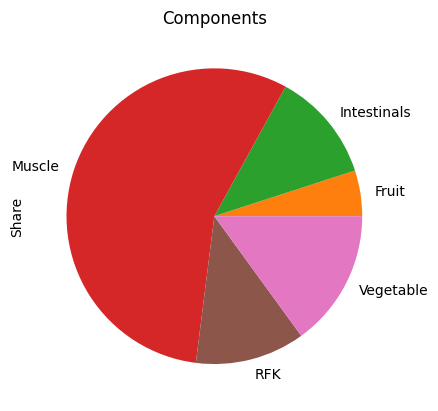

In [515]:
# plot components
components_pie_chart.plot(kind='pie', y='Share', title='Components', legend=False)

### Intestinals
The optimal composition of intestinals:
- $\frac{2}{5}$ liver
- $\frac{1}{5}$ heart
- $\frac{1}{5}$ kidney
- $\frac{1}{5}$ spleen

<Axes: title={'center': 'Intestinals'}, ylabel='Share'>

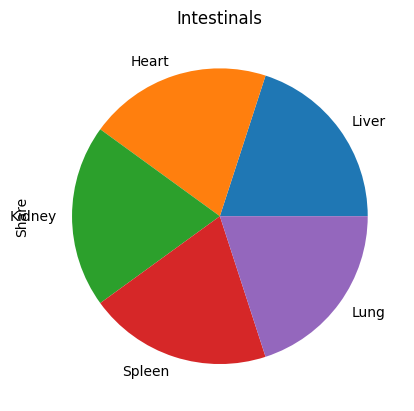

In [ ]:
intestinal_share_df = pd.DataFrame([
    ['Liver', 1/5],
    ['Heart', 1/5],
    ['Kidney', 1/5],
    ['Spleen', 1/5],
    ['Lung', 1/5]
], columns=['Intestinal', 'Share']).set_index('Intestinal')
intestinal_share_df.plot(kind='pie', y='Share', title='Intestinals', legend=False)

### Fish
Fisch ist ein wichtiger Bestandteil der BARF Ration, um den Vitamin D Haushalt zu decken. Es wird empfohlen 1x pro Woche den Muskelfleischanteil durch Fisch zu ersetzen. Dazu eignen sich insbesondere Vitamin D haltige Fische wie Sprotten, Hering, Lachs, Sardellen und Forelle. 

In [517]:
weekly_fish_amount = round(daylydemand * modules_share['Meat'])
print(f'The suggested amount of fish per week is {weekly_fish_amount}g.')

The suggested amount of fish per week is 560g.


You can manually adjust the amount of fish if desired. If you do not want to feed fish, set `weekly_fish_amount` to 0. In this case, remember to substitute fish with Lebertran to supply enough vitamin D. 

In [518]:
# adjusted fish amount
weekly_fish_amount = 500

## Products

In [519]:
products = [
    # Product(name='AllesVomRind', category='Beef', volume=1000, price=6.95, muscle=0.5, pansen=0.1, blaettermagen=0.1, liver=0.15*.34, kidney=0.15*.17, heart=0.15*0.17, spleen=0.15*.16, lung=0.15*0.16, rfk=0.15, fat=0.124),
    # Product(name='AllesVomLamm', category='Lamb', volume=1000, price=8.15, muscle=0.54, pansen=0.11, blaettermagen=0.11, liver=0.18*.34, kidney=0.18*.17, heart=0.18*0.17, spleen=0.18*.16, lung=0.18*0.16, rfk=0.15, fat=0.185),
    # Product(name='AllesVomHuhn', category='Chicken', volume=1000, price=6.55, muscle=0.65, liver=.1, heart=0.05, rfk=0.2, fat=0.13),
    # Product(name='AllesVomPferd', category='Horse', volume=1000, price=9.49, muscle=0.55+0.2, liver=0.2*0.15, heart=0.2*0.15, kidney=0.2*0.15, spleen=0.2*0.15, lung=0.2*0.15, rfk=0.1, fat=0.13),
    
    # Beef
    # Product(name='RindermuskelfleischDurchwachsen', category='Beef', volume=1000, price=8.75, muscle=1, fat=0.283),
    # Product(name='Ochsenmaul', category='Beef', volume=1000, price=5.15, muscle=1, fat=0.03),
    # Product(name='Rinderinnereienmix', category='Beef', volume=1000, price=6.15, liver=0.34, kidney=0.17, heart=0.17, spleen=0.16, muscle=0.16, fat=0.054),
    # Product(name='Rinderpansen', category='Beef', volume=1000, price=3.75, pansen=1, fat=0.099),
    # Product(name='Blättermagen', category='Beef', volume=1000, price=3.75, blaettermagen=1, fat=0.059),
    # Product(name='Rinderherz', category='Beef', volume=1000, price=6.15, heart=1, fat=0.059),
    # Product(name='Kalbsmilz', category='Beef', volume=500, price=2.95, spleen=1, fat=0.044),
    # Product(name='Rinderniere', category='Beef', volume=500, price=3.45, kidney=1, fat=0.115),
    # Product(name='Rinderleber', category='Beef', volume=500, price=3.55, liver=1, fat=0.041),
    # Product(name='Rinderlunge', category='Beef', volume=500, price=3.55, lung=1, fat=0.02),

    # Horse
    Product(name='Pferdemuskelfleisch', category='Horse', volume=1000, price=9.99, muscle=1, fat=0.046),
    Product(name='Pferdeinnereienmix', category='Horse', volume=1000, price=8.79, liver=1/5, kidney=1/5, heart=1/5, spleen=1/5, lung=1/5, fat=0.075),
    Product(name='Pferdeherzen', category='Horse', volume=1000, price=8.29, heart=1, fat=0.04),

    # Chicken
    # Product(name='Huehnermuskelfleisch', category='Chicken', volume=1000, price=7.55, muscle=1, fat=0.022),
    # Product(name='Putenmuskelfleisch ', category='Chicken', volume=1000, price=7.55, muscle=1, fat=0.22),

    # Lamb
    # Product(name='Lammmuskelfleisch ', category='Lamb', volume=1000, price=9.59, muscle=1, fat=0.257),

    # # RFK
    # Product(name='Huehnerherzen', category='Chicken', volume=500, price=3.95, heart=1, fat=0.075),
    # Product(name='Putenhälse', category='Chicken', volume=1000, price=4.95, rfk=1, fat=0.11),
    # Product(name='Hühnerhälse', category='Chicken', volume=1000, price=4.55, rfk=1, fat=0.077),
    # Product(name='Entenhälse', category='Chicken', volume=1000, price=4.95, rfk=1, fat=0.108),
    # Product(name='Lammrippenknochen', category='Lamb', volume=1000, price=4.75, rfk=1, fat=0.032),
    # Product(name='Kalbsbrustbeinknochen', category='Beef', volume=1000, price=3.95, rfk=1, fat=0.418),
    Product(name='Pferdenackenknochen', category='Horse', volume=1000, price=7.69, rfk=1, fat=0.036),

    # Fett
    # Product(name='Lammfett', category='Lamb', volume=500, price=3.65, muscle=1, fat=0.638),
    Product(name='Pferdefett', category='Horse', volume=500, price=4.05, muscle=1, fat=0.628),
    # Product(name='Rinderfett', category='Beef', volume=500, price=4.25, muscle=1, fat=0.812),
    # Product(name='Hühnerfett', category='Chicken', volume=500, price=2.95, muscle=1, fat=0.795),

    Product(name='Lachs', category='Fish', volume=500, price=4.95, muscle=1, fat=0.248),
    
    # Haustier
    # Product(name='HuehnerhaelseH', category='Chicken', volume=1000, price=3.99, rfk=1, fat=0.22),
    # Product(name='HuehnerfettH', category='Chicken',  volume=1000, price=3.99, muscle=1, fat=0.995),
    # Product(name='HuehnerfleischH', category='Chicken', volume=1000, price=8.99, muscle=1, fat=0.142),
    # Product(name='RinderfettH', category='Beef', volume=500, price=2.98, muscle=1, fat=0.91),
    # Product(name='RindermuskelfleischwuerfelH', category='Beef', volume=500, price=4.29, muscle=1, fat=0.09),
    # Product(name='RindermilzWuerfelH', category='Beef', volume=500, price=2.49, spleen=1, fat=0.051),
    # Product(name='RinderleberAmStueckH', category='Beef', volume=500, price=2.49, liver=1, fat=0.085),
    # Product(name='RindfleischKlumpenH', category='Beef', volume=2000, price=16.99, muscle=1, fat=0.12),

    # Vegetable & Fruit
    Product(name='Vegetables', category='Vegetables', volume=1, price=0.001, vegetable=1, fat=0),
    Product(name='Fruit', category='Fruits', volume=1, price=0.001, fruit=1, fat=0)
] 

df, content_components_df, intest_components_df = process_products(products, component_share)

## Inventory
Account for the products you have in your inventory.

In [520]:
# 08.04.2025
add_inventory(df, 'Pferdefett', 400)
# add_inventory(df, 'Rinderinnereienmix', 500)
# add_inventory(df, 'RindermuskelfleischDurchwachsen', 100)
# add_inventory(df, 'Blättermagen', 750)
# # add_inventory(df, 'Rinderpansen', 750)
# add_inventory(df, 'Kalbsbrustbeinknochen', 300)
# add_inventory(df, 'Hühnerfett', 150)
# add_inventory(df, 'Lammrippenknochen', 500)
# # add_inventory(df, 'Huehnermuskelfleisch', 600)
# add_inventory(df, 'Rinderleber', 150)
# # add_inventory(df, 'Rinderlunge', 50)
# add_inventory(df, 'Kalbsmilz', 200)
# add_inventory(df, 'Rinderniere', 200)
# add_inventory(df, 'AllesVomLamm', 150)
# add_inventory(df, 'Lachs', 1*500)

df.sort_values(by='Price [€/kg]').set_index('Name')

,Category,Inventory,Price [€/kg],Price,Volume,Fat
Name,,,,,,
Vegetables,Vegetables,0,1.00,0.001,1,0.000
Fruit,Fruits,0,1.00,0.001,1,0.000
Pferdenackenknochen,Horse,0,7.69,7.690,1000,0.036
Pferdefett,Horse,400,8.10,4.050,500,0.628
Pferdeherzen,Horse,0,8.29,8.290,1000,0.040
Pferdeinnereienmix,Horse,0,8.79,8.790,1000,0.075
Lachs,Fish,0,9.90,4.950,500,0.248
Pferdemuskelfleisch,Horse,0,9.99,9.990,1000,0.046


Validate input data

In [521]:
assert 'Fish' in df['Category'].values, 'No fish in products'
for c in component_share.index:
    assert content_components_df[['Component', 'Share']].groupby('Component').sum().loc[c]['Share'] > 0, f'No {c} in products'

In [522]:
demand_df

,Share
Component,
Fruit,245.0
Intestinals,588.0
Muscle,2744.0
RFK,588.0
Vegetable,735.0


## Model
### Symbols

In [523]:
m = Container()

# Sets
p = m.addSet('p', description='Products', records=df['Name'])
c = m.addSet('c', description='Components', records=component_share.index)
i = m.addSet('i', description='Intestines', records=intestinal_share_df.index)

GREENS = m.addSet('GREENS', p, records=df[(df['Category'] == 'Fruits') | (df['Category'] == 'Vegetables')][['Name', 'Category']])
FISH = m.addSet('FISH', p, records=df[df['Category'] == 'Fish'][['Name', 'Category']])

# create parameters
price = m.addParameter('price', p, records=df[['Name', 'Price']], description="price of product p")

volume = m.addParameter('volume', p, records=df[['Name', 'Volume']], 
                        description='volume of product p')

inventory = m.addParameter('inventory', p, records=df[['Name', 'Inventory']], 
                           description='inventory of product p')

fat = m.addParameter('fat', p, records=df[['Name', 'Fat']], description='fat share of product p')

demand = m.addParameter('demand', c, records=demand_df.reset_index(), description='demand for each component')

content_components = m.addParameter('content_components', [c, p], records=content_components_df, 
                                    description='components of product p')

intestinal_components = m.addParameter('intestinal_components', [i, p], records=intest_components_df,
                                       description='intestinal components of product p')

intestinal_share = m.addParameter('intestinal_share', i, records=intestinal_share_df.reset_index(),
                           description='intestinal share')

# create scalars
nweeks = m.addParameter('weeks', records=weeks, description="number of weeks")
weekly_demand = m.addParameter('weeklydemand', records=weeklydemand, description="weekly demand")
m.addParameter('weight', records=weight, description="dogs desired body weight")
m.addParameter('perc', records=perc, description="percent of body weight")
m.addParameter('activity', records=activity, description="dog activity level")
m.addParameter('fatlb', records=fat_lb, description="lower bound on fat")
m.addParameter('fatub', records=fat_ub, description="upper bound on fat")
m.addParameter('fish_amount', records=weekly_fish_amount, description="amount of fish")

# create variables
X = m.addVariable('X', 'positive', p, description='Amount of product p')
Y = m.addVariable('Y', 'integer', p, description='Auxiliary variable to avoid odd numbers for X')
Z = m.addVariable('Z', 'integer', p, description='Number of packs to buy from product p')

### Equations

In [524]:
totalLB = Equation(m, name='totalLB', description='Minimum total quantity')
totalUB = Equation(m, name='totalUB', description='Maximum total quantity')
components = Equation(m, name='components', domain=[c], description='Account for the quantity of each component')
intestines = Equation(m, name='intestines', domain=[i], description='Account for the quantity of each intestinal component')
fish_day = Equation(m, name='fish_day', description='Include one fish day')
fatLB = Equation(m, name='fat_lb',  description='Account for the minimal amount of fat')
fatUB = Equation(m, name='fat_ub',  description='Account for the maximal amount of fat')
buy = Equation(m, name='buy', domain=[p], description='Determine the number of packs to buy')
rounding = Equation(m, name='rounding', domain=[p], description='Prohibit uneven amounts')
# bones = Equation(m, name='bones')

# objective = Sum(p, (price[p] / volume[p]) * X[p]) + Sum(p, price[p] * Z[p])
objective = Sum(p, price[p] * Z[p])
totalLB[...] = Sum(p, X[p]) >= 0.98 * weekly_demand * nweeks
totalUB[...] = Sum(p, X[p]) <= 1.02 * weekly_demand * nweeks
components[c] = Sum(p, content_components[c, p] * X[p]) >= nweeks * demand[c] - 26
intestines[i] = Sum(p, intestinal_components[i, p] * X[p]) >= intestinal_share[i] * nweeks * demand['Intestinals']
fish_day[...] = Sum(FISH[p], X[p]) == weekly_fish_amount * nweeks
fatLB[...] = Sum(p, fat[p] * X[p]) >= fat_lb * Sum(p, X[p])
fatUB[...] = Sum(p, fat[p] * X[p]) <= fat_ub * Sum(p, X[p])
buy[p] = inventory[p] + volume[p] * Z[p] >= X[p]
rounding[p] = X[p] == 50 * Y[p]
# bones[...] = X['Kaninchenkarkasse'] >= 0.5 * (X['Huehnerhaelse'] + X['Huehnerkarkasse']) 


You can limit specific ingredients by defining a maximum amount, e.g. ``X.up['Ochsenmaul'] = 100``, limits the amount included in the plan to 100g.

In [525]:
# X.up['Ochsenmaul'] = 0
# # X.up['Huehnerherzen'] = 0
# X.up['Huehnermuskelfleisch'] = 2000
# X.up['Putenmuskelfleisch'] = 2000

# Z.up['Pferdenackenknochen'] = 2
# Z.up['AllesVomHuhn'] = 0
# Z.up['AllesVomRind'] = 0
# Z.up['Hühnerhälse'] = 0

In [526]:
barf = Model(
    m,
    name="BARF",
    equations=m.getEquations(),
    # equations=[totalLB, totalUB, components, fatLB, fatUB, rounding, buy],
    problem="MIP",
    sense=Sense.MIN,
    objective=objective,
)

# barf.solve(output=sys.stdout, options=Options(listing_file="my.lst"), solver='cplex', solver_options={'iis': 1})
barf.solve( 
    solver='cplex', solver_options={'iis': 1},
    options=Options(listing_file="my.lst", log_file="my.log", equation_listing_limit=100, variable_listing_limit=100)
    )
# barf.compute_infeasibilities()


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,237.55,32,25,MIP,CPLEX,0.031


# Review Results
Amount of Products

In [533]:
X.l.records.loc[X.l.records['level'] > 0]

,p,level
0,Pferdemuskelfleisch,11350.0
1,Pferdeinnereienmix,4000.0
3,Pferdenackenknochen,3650.0
4,Pferdefett,2100.0
5,Lachs,3000.0
6,Vegetables,4400.0
7,Fruit,1450.0


Number of packs to buy of product

In [530]:
Z.l.records.loc[Z.l.records['level'] > 0]

,p,level
0,Pferdemuskelfleisch,12.0
1,Pferdeinnereienmix,4.0
3,Pferdenackenknochen,4.0
4,Pferdefett,4.0
5,Lachs,6.0
6,Vegetables,4400.0
7,Fruit,1450.0


## BARF Ratio Statistics

In [532]:
final_percent = X.records['level'].sum() / (7 * weeks) / (weight * 1000) * 100
tar_percent = activity * perc * 100
total_cost = round((X.records['level'] / 1000 * df['Price [€/kg]']).sum(), 2)
daily_cost = total_cost / (7 * weeks)
fat = (X.records['level'] * df['Fat']).sum() / X.records['level'].sum() * 100
r = pd.DataFrame({
    'Index': ['Final Percent [%]', 'Targeted Percent [%]', 'Total Cost [€]', 'Daily Cost [€]', 'Fat [%]', 'Daily Demand [g]'],
    'Column': [final_percent, tar_percent, total_cost, daily_cost, fat, daylydemand]
}).round(2)
r

,Index,Column
0,Final Percent [%],2.04
1,Targeted Percent [%],2.00
2,Total Cost [€],229.18
3,Daily Cost [€],5.46
4,Fat [%],10.07
5,Daily Demand [g],700.00


## Supplements
Don't forget to add salt, iodine, and oil.

### Salt:
1-2 Pinches per week

### Jod (Seealgenmehl/Ascophyllum nodosum):
- [Seealgen Blog](https://www.barf-check.de/seealgen-bei-barf/)
- [Seealgen Rechner](https://www.barf-kultur.de/Seealgenrechner)

### Oil:
- 1ml oil per 100g food (1 tee spoon = 5 ml)
- Salmon oil, Linseed oil, and Hemp seed oil are well balanced oils
- Stabilize oil with Vitamin E (10IE pro ml oil)
- [Öl Blog](https://www.der-barf-blog.de/2015/11/barf-oel.html)